Patrick Kinney, DJ, Andersen Ader


# The Write-Up

## Background


This idea started with thinking about stock market modeling.  Due to the many issues even getting reliable stock market data we looked for other sources of data.  Because one of our members was playing a lot of the game Hypixel Skyblock at the time.  And there was a reliable and free API that could be used to get the price data.  It was decided that we would try to model the correlation between an items price on the bazaar and the mayor perks.  


### Terminology




#### Hypixel Skyblock
Hypixel Skyblock (hereafter Skyblock) is an MMORPG created entirely within a Minecraft server.  While it can be accessed through an unmodified Minecraft instance the server uses a number of custom systems to completely overhaul the gameplay.  It has a fairly large population of players with there being tens of thousands of people online daily.  

#### Bazaar
The Bazaar is one of the primary markets in the game Skyblock.  It is a simple interface where players can buy and sell many of the materials in the game.  In terms of player interactions, players can create buy and sell orders either with coins or the material respectively, and other players can choose to sell to those buy orders or buy from the sell orders.  This is what creates our market that we look at.  

#### Mayors & Perks
Every Skyblock year (approx. 5 days) a "Mayor" is elected by the players.  There are eleven mayors each having between three and four perks.  These perks impact everything in the game from skill xp to the taxes paid by players in the various markets.  Therefor these mayors have a significant impact on what players do in game with many players tailoring their playstyle entirely around who is mayor at a given time.  

#### Acronyms



SLASHED Pricing → SP

Slayer XP Buff → SX

Pathfinder → PF

Prospection → PS

Mining XP Buff → MXP

Mining Fiesta → MF

Molten Forge → MFrge

Lucky! → LU

Mythological Ritual → MR

Pet XP Buff → PX

Sharing is Caring → SiC

Long Term Investment → LTI

Volume Trading → VT

Stock Exchange → SE

Shopping Spree → SS

Pelt-pocalypse → PP

GOATed → GOAT

Blooming Business → BB

Pest Eradicator → PE

Sweet Benevolence → SB

Extra Event → EE

A Time for Giving → ATG

Chivalrous Carnival → CC

Fishing XP Buff → FXP

Luck of the Sea 2.0 → L2.0

Fishing Festival → FF

Double Trouble → DT

Marauder → Mrd

EZPZ → EZ

Benediction → Bene

QUAD TAXES!!! → QT

TURBO MINIONS!!! → TM

DOUBLE MOBS HP!!! → DMHP

MOAR SKILLZ!!! → MSK

Perkpocalypse → Pkp

Statspocalypse → Spc

Jerrypocalypse → Jrp

Bribe → Brb

Darker Auctions → DA


## The Data


The data was taken from the freely available *SkyApi* from Coflnet a group that hosts many resources related to the Skyblock markets.  Fortunately for us they had a few readily available API endpoints that contained the data we needed.  Very helpfully two endpoints existed and were free to use, the mayor history endpoint (`https://sky.coflnet.com/api/mayor?from={}&to={}`) and the bazaar item history endpoint (`https://sky.coflnet.com/api/bazaar/COAL/history?start={}&end={}`).  

From here we would sanitize the data, and remove unneeded entries such as the candidates from the mayor elections.  Next we would merge the dataframes to get the complete picture of time, sell price, buy price, and the active perks.  Finally to make it work for the model we had break the perks which till then were listed within a single column into a separate column for each perk with a binary flag for which was active.  


## The Model


We used linear regression to establish the correlation of each perk to the price of coal. We assigned time frames where a perk was active to 1, and timeframes where it was not active to 0. We then created a correlation matrix. While there was some value to a correlation matrix, as some perks had a higher likelihood to appear together, our main focus was on how each perk correlated with the purchase price of coal.

## The Results

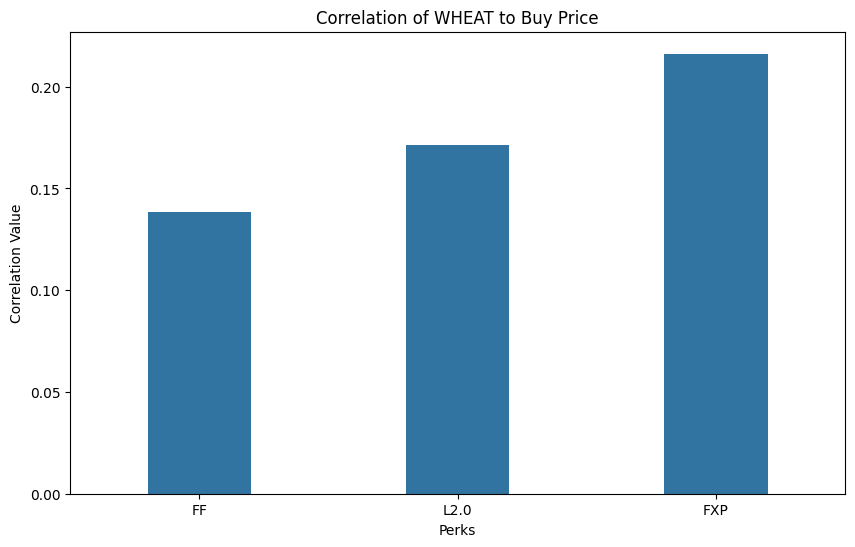
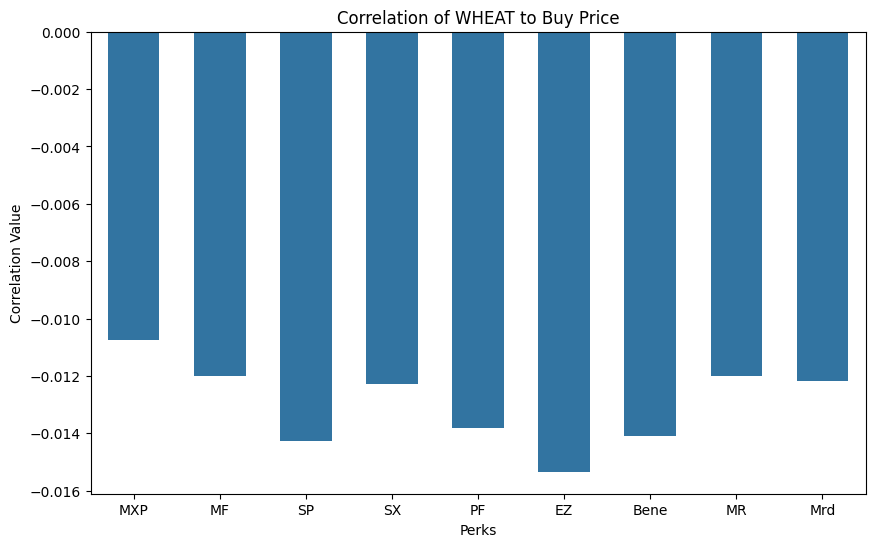
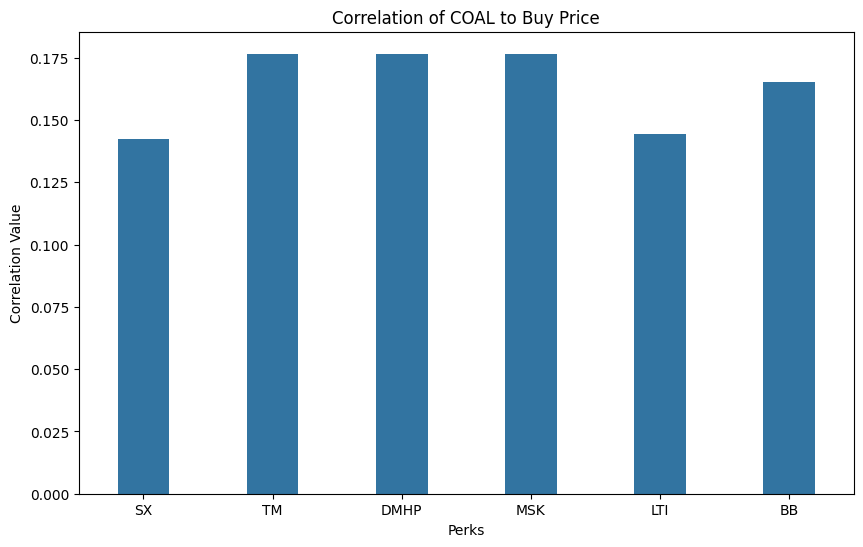
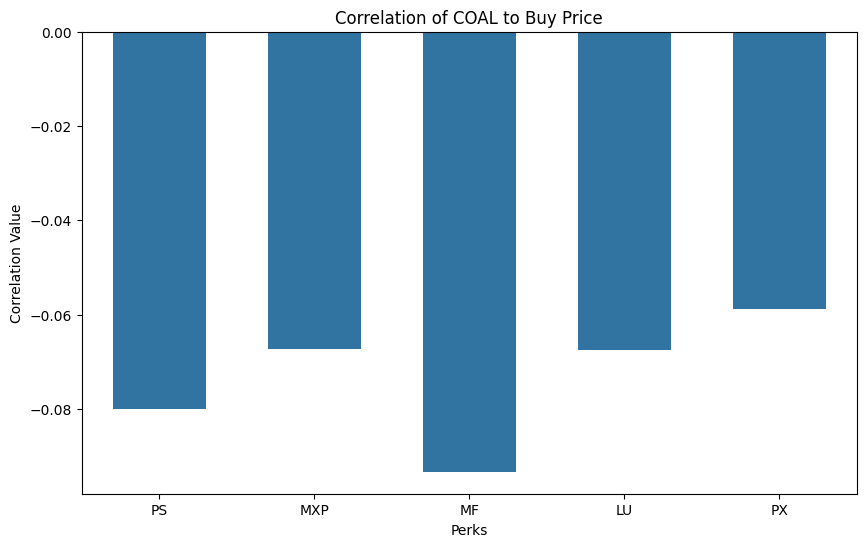

The four graphs above represent two of the most bought items in the Bazaar and their highest correlated perks. These graphs show how influential any one perk  can be to the average bought price of items. Additionally, it also highlights the volatility of any item compared to the amount of perks and their strength influencing the item's average bought price on the Bazaar.

This is highlighted with the positive correlation from perks with wheat. Only three perks significantly have the buying price go up, however they are massive increases to the price. On the other hand, looking at the negatives; there are a significant number of perks that affect the wheat price negatively however to a much lesser degree.

## The Challenges

We encountered many challenges in getting this finished.  A simple one that was run into fairly early was with merging the bazaar history and mayor perk dataframes as they use different formats to store their time.  Fortunately pandas contained tools to resolves this but it still took a while to find that tool and make it work for our data.

## Where to go From Here

The logical next step from here would be to generalize the code contained here to work on any item in the bazaar.  A few variables are hard coded that would need to be changed to be easily manipulated but that would likely not be a colossal undertaking.  From there it could be interesting to incorporate time into the model as activity on the markets likely depends on when more players are active and could increase volatility.

# Code

This is all imports and creating dependenceies that will be used further on.  

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
BASE_URL = "https://sky.coflnet.com/api"

response = requests.get('https://sky.coflnet.com/api/bazaar/COAL/history/hour')
#a list of all perks
perks = ['SLASHED Pricing','Slayer XP Buff','Pathfinder','Prospection','Mining XP Buff','Mining Fiesta','Molten Forge',
         'Lucky!','Mythological Ritual','Pet XP Buff','Sharing is Caring','Long Term Investment','Volume Trading',
         'Stock Exchange','Shopping Spree','Pelt-pocalypse','GOATed','Blooming Business','Pest Eradicator',
         'Sweet Benevolence','Extra Event','A Time for Giving','Chivalrous Carnival','Fishing XP Buff','Luck of the Sea 2.0',
         'Fishing Festival','Double Trouble','Marauder','EZPZ','Benediction','QUAD TAXES!!!','TURBO MINIONS!!!',
         'DOUBLE MOBS HP!!!','MOAR SKILLZ!!!','Perkpocalypse','Statspocalypse','Jerrypocalypse','Bribe','Darker Auctions']

Here is where we fetch the item data from the bazaar API endpoints.  Some values are hardcoded due to old data being challenging to work with.  

In [ ]:
#returns the prices of  by inputting the item, mayor, and setting
#H = hour | D = day | W = week | A = all
def price_by_item(item_id, setting):
  if setting == "H":
    item_price_url = f"{BASE_URL}/bazaar/{item_id}/history/" + "hour"
  elif setting == "D":
    item_price_url = f"{BASE_URL}/bazaar/{item_id}/history/" + "day"
  elif setting == "W":
    item_price_url = f"{BASE_URL}/bazaar/{item_id}/history/" + "week"
  else:
    item_price_url = f"{BASE_URL}/bazaar/{item_id}/history?start=2023-01-01&end=2026-01-01"

  response = requests.get(item_price_url)

  if response.status_code == 200:
    data = response.json()
    price_data = []
    for record in data:
      timestamp = record.get('timestamp')
      buy_price = record.get('buy')
      sell_price = record.get('sell')

      price_data.append({
          'timestamp': timestamp,
          'buy_price': buy_price,
          'sell_price': sell_price
      })

    df = pd.DataFrame(price_data)
    return df

  else:
    print(f"Failed to get data :(")
    return None

These two functions and the later function call get all of the mayor history and remove unneeded values from the dataframe.  

In [ ]:
# Returns a pandas dataframe object created from the JSON response to the /mayor?from={}&to{} Coflnet api call
def getMayorHistory(start: str, end: str):
  response = requests.get(f"{BASE_URL}/mayor?from={start}&to={end}")
  df = pd.json_normalize(response.json())
  df = cleanMayors(df)
  return df

# cleans the given dataframe to only include start date, end date, and a perks list.
def cleanMayors(df):
  df.drop(columns=['candidates', 'year', 'winner.key', 'winner.name'], inplace=True)
  for index, row in df.iterrows():
    perkList = []
    dfVal = row['winner.perks']
    stringVal = str(dfVal)
    for perk in perks:
      if perk in stringVal:
        perkList.append(perk)
    df.iloc[index, 2] = perkList
  return df

In [ ]:
df = getMayorHistory('2024-01-01', '2026-01-01')

This is where we merge the mayor and bazaar item data into a unified dataframe as well as transform the perks from a list to their own columns.  

In [ ]:
#the api produced non-matching date times, these needed to be matched to a single
itemname = "COAL"
item_df = price_by_item(itemname, "A")
item_df['timestamp'] = pd.to_datetime(item_df['timestamp'], utc=True, format='mixed')
item_df['timestamp'] =  item_df['timestamp']
df.start = pd.to_datetime(df['start'])
df.end = pd.to_datetime(df['end'], utc = True)
perk_list = []

#get all unique perks from the dataset and append a column to the data frame for it,
for mayor_index, mayor in df.iterrows():
  perks = mayor['winner.perks']
  for perk in perks:
    if perk not in perk_list:
      perk_list.append(perk)
      item_df[perk] = 0

#check each item, and get it's corresponding mayor data, and set each active perk to 1
for item_index,item in item_df.iterrows():
  for mayor_index, mayor in df.iterrows():
    if item_df['timestamp'].iloc[item_index] > df['start'].iloc[mayor_index] and item_df['timestamp'].iloc[item_index] < df['end'].iloc[mayor_index]:
      for perk in  df['winner.perks'].iloc[mayor_index]:
        item_df.loc[item_index, perk] = 1 # set the perk column to one if perk active.

In [ ]:
item_df

Making the later graph easier to understand.

In [ ]:
perks_acronyms = {
    'SLASHED Pricing': 'SP',
    'Slayer XP Buff': 'SX',
    'Pathfinder': 'PF',
    'Prospection': 'PS',
    'Mining XP Buff': 'MXP',
    'Mining Fiesta': 'MF',
    'Molten Forge': 'MFrge',
    'Lucky!': 'LU',
    'Mythological Ritual': 'MR',
    'Pet XP Buff': 'PX',
    'Sharing is Caring': 'SiC',
    'Long Term Investment': 'LTI',
    'Volume Trading': 'VT',
    'Stock Exchange': 'SE',
    'Shopping Spree': 'SS',
    'Pelt-pocalypse': 'PP',
    'GOATed': 'GOAT',
    'Blooming Business': 'BB',
    'Pest Eradicator': 'PE',
    'Sweet Benevolence': 'SB',
    'Extra Event': 'EE',
    'A Time for Giving': 'ATG',
    'Chivalrous Carnival': 'CC',
    'Fishing XP Buff': 'FXP',
    'Luck of the Sea 2.0': 'L2.0',
    'Fishing Festival': 'FF',
    'Double Trouble': 'DT',
    'Marauder': 'Mrd',
    'EZPZ': 'EZ',
    'Benediction': 'Bene',
    'QUAD TAXES!!!': 'QT',
    'TURBO MINIONS!!!': 'TM',
    'DOUBLE MOBS HP!!!': 'DMHP',
    'MOAR SKILLZ!!!': 'MSK',
    'Perkpocalypse': 'Pkp',
    'Statspocalypse': 'Spc',
    'Jerrypocalypse': 'Jrp',
    'Bribe': 'Brb',
    'Darker Auctions': 'DA'
}


This section creates the correlation matrix, filters it to only those entries with a high correlation and displays a simple graphic to show them off.

In [ ]:

correlation_matrix = item_df.corr()
correlation_to_price = correlation_matrix["buy_price"][3:]
filter_condition_high = (correlation_to_price > 0.13)
filter_condition_low = (correlation_to_price < -0.1)
filtered_corr_high = correlation_to_price[filter_condition_high]
filtered_corr_low = correlation_to_price[filter_condition_low]
filtered_corr = pd.concat([filtered_corr_high, filtered_corr_low]) # refuses to grab negative values?

filtered_corr = filtered_corr.replace(perks_acronyms)

plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_corr.index, y=filtered_corr.values, width=0.4)


plt.xticks(ticks=range(len(filtered_corr)), labels=[perks_acronyms.get(c, c) for c in filtered_corr.index])


plt.title(f'Correlation of {itemname} to Buy Price')
plt.xlabel('Perks')
plt.ylabel('Correlation Value')


This final section creates the correlation matrix, filters it to only those entries with a low correlation and displays a simple graphic to show them off.

In [ ]:
negative_values = correlation_to_price[correlation_to_price < -0.04] # works now in the morning


plt.figure(figsize=(10, 6))
sns.barplot(x=negative_values.index, y=negative_values.values, width=0.6)


plt.xticks(ticks=range(len(negative_values)), labels=[perks_acronyms.get(c, c) for c in negative_values.index])

plt.title(f'Correlation of {itemname} to Buy Price')
plt.xlabel('Perks')
plt.ylabel('Correlation Value')